In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
from walk_forward_module import walk_forward


pd.set_option('display.float_format', '{:.2f}'.format)


## 資料DataFrame

In [42]:
df = yfin.download('^TWII', start = '2023-5-1', end = '2024-7-30')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

[*********************100%%**********************]  1 of 1 completed


# function

In [43]:
def get_llt(df, a):
    llt = np.zeros(len(df))
    llt[0] = df['close'].iloc[0]
    llt[1] = (1 - a) * df['close'].iloc[0] + a * df['close'].iloc[1]
    for n in range(2, len(df)):
        llt[n] = ((a - (a ** 2)/4) * df['close'].iloc[n]) + (((a ** 2)/2) * df['close'].iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * df['close'].iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    
    df['llt'] = llt
    df['llt_slope'] = np.nan

    for i in range(0, len(df)):
        df.loc[df.index[i], 'llt_slope'] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
    return df


def bolinger_band(df, p, q, o, rolling, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q, o = o, rescale = False)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = 20).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = 20).mean()

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['close']) / df['close']
    df['lower_deviation'] = (df['close'] - df['bolinger_lower']) / df['close']

    df['upper_rise'] = df['upper_deviation'] >= upper_threshold
    df['lower_down'] = df['lower_deviation'] >= lower_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_u_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_l_threshold

    return df

def get_middle(df):
    
    df['middle'] = np.nan
    df.loc[df.index[0], 'middle'] = df['close'].iloc[0]

    for i in range(1, len(df)):

        upper_change = abs(df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1])
        lower_change = abs(df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1])
        
        peak_upward = upper_change > lower_change
        peak_downward = upper_change < lower_change
    
        if peak_upward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_lower_smooth'].iloc[i]) / (i + 1)
            # df.loc[df.index[i], 'middle'] = ((df['middle'].iloc[i - 1] * (i)) + df['bolinger_lower']) / (i + 1)
        elif peak_downward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_upper_smooth'].iloc[i]) / (i + 1)
            # df.loc[df.index[i], 'middle'] = ((df['middle'].iloc[i - 1] * (i)) + df['bolinger_upper']) / (i + 1)
    
    return df



# strategy

In [44]:
def llt_strategy(df, fund, feePaid, a, p, q, o, rolling, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, o = o, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    df['Bull'] = False
    df['Bear'] = False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
        df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)

        # 進出場邏輯
        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = ((df['bolinger_upper'].iloc[i] < df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition4) | ((df['bolinger_lower'].iloc[i] < df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition6)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = ((df['bolinger_upper'].iloc[i] > df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition3) | ((df['bolinger_lower'].iloc[i] > df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition5)

        if BS == None:
            if df['Bull'].iloc[i]:
                if entryLong:
                    BS = 'B'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1

            elif df['Bear'].iloc[i]:
                if entryShort:
                    BS = 'S'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1

        elif BS == 'B':
            
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitLong:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                BS = None

                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitShort:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] += 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                BS = None

                profit_fee_realized = pl_round - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] += unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
            
        if t is not None:
            if pd.notna((ret_df['buy_time'].iloc[t]) and pd.notna(ret_df['sell_time'].iloc[i + 1])):
                hold_duration = (ret_df['sell_time'].iloc[i + 1] - ret_df['buy_time'].iloc[t]).days
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = hold_duration
            elif pd.notna((ret_df['sellshort_time'].iloc[t]) and pd.notna(ret_df['buytocover_time'].iloc[i + 1])):
                hold_duration = (ret_df['sellshort_time'].iloc[i + 1] - ret_df['buytocover_time'].iloc[t]).days
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = hold_duration
        else:
            print(f"Warning: t is not assigned before using it at index {i}")

        # print(f'Index: {i}, df["Bull"].iloc[i]: {df["Bull"].iloc[i]}, entryLong: {entryLong}, entryShort: {entryShort}')


    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return ret_df, equity

# calculate metrics

In [45]:
def calculate_metrics(ret_df, equity):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum()) + min((ret_df['sellshort'] > 0).sum(), (ret_df['buytocover'] > 0).sum())
    winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = ret_df['profit_list'].mean()
    std_ret = ret_df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    return {
        'Duration' :  duration,
        'Profit': profit,
        'Return': ret,
        'Max DrawDown': mdd,
        'Caimar Ratio': calmarRatio,
        'Trade Times': tradeTimes,
        'Win Rate': winRate,
        'Profit Factor': profitFactor,
        'sharp_ratio': sharp
    }

# optimize

In [46]:
def optimize(a_range, o_range, upper_threshold_range, lower_threshold_range, retrace_u_threshold_range, retrace_l_threshold_range, df, fund, feePaid, p, q, rolling, num_vol):
    
    results = []

    for a in a_range:
        # for o in o_range:
        #     for upper_threshold in upper_threshold_range:
        #         for lower_threshold in lower_threshold_range:
        #             for retrace_u_threshold in retrace_u_threshold_range:
        #                 for retrace_l_threshold in retrace_l_threshold_range:
        df_copy = df.copy()

        ret_df, equity = llt_strategy(
            df_copy, fund = fund, feePaid = feePaid, a = a, p = p, q = q, o = o, rolling = rolling, num_vol = num_vol,
            upper_threshold = upper_threshold, lower_threshold = lower_threshold,
            retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold
        )

        metrics = calculate_metrics(ret_df, equity)

        result = {
            'a': a,
            'o': o,
            'upper_threshold': upper_threshold,
            'lower_threshold': lower_threshold,
            'retrace_u_threshold': retrace_u_threshold,
            'retrace_l_threshold': retrace_l_threshold,
            'metrics': metrics
        }
        results.append(result)
        print(f'a: {a}, o: {o}, upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold}, retrace_u_threshold: {retrace_u_threshold}, retrace_l_threshold: {retrace_l_threshold}')

        results_df = pd.DataFrame(results)
        return results_df

# parametors

In [47]:
a = np.arange(0.1, 1, 0.1)
p = 1
q = 1
# o = np.arange(0, 0.1, 0.01)
o = 0
num_vol = 1
rolling = 20
# upper_threshold = np.arange(0.01, 0.1, 0.01)
# lower_threshold = np.arange(0.01, 0.1, 0.01)
# retrace_u_threshold = np.arange(0.01, 0.1, 0.01)
# retrace_l_threshold = np.arange(0.01, 0.1, 0.01)
upper_threshold = 0.5
lower_threshold = 0.5
retrace_u_threshold = 0.5
retrace_l_threshold = 0.5
fund = 1000000
feePaid = 600

# execute

In [48]:
results_df = optimize(
    a_range = a, o_range = o,
    upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,
    retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,
    df = df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol)

a: 0.1, o: 0, upper_threshold: 0.5, lower_threshold: 0.5, retrace_u_threshold: 0.5, retrace_l_threshold: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_20958/4110724753.py:10: RuntimeWarning: invalid value encountered in scalar divide
  calmarRatio = ret / mdd
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_20958/4110724753.py:12: RuntimeWarning: invalid value encountered in scalar divide
  winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_20958/4110724753.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  sharp = (mean_ret - risk_free_rate) / std_ret


## extract

In [49]:
# 想對什麼排序就將哪個設為metric_column
def extract_best_params(results_df, optimize_indicator, metric_column = 'metrics', ascending=False):
    results_df[f'optimize_metric'] = results_df[metric_column].apply(lambda x: x[optimize_indicator])
    sorted_df = results_df.sort_values(by='optimize_metric', ascending=ascending)
    best_params = sorted_df.iloc[0].to_dict()
    return best_params

# walk forward optimize

In [50]:
# 执行 walk forward 回测
best_params = extract_best_params(results_df = results_df, optimize_indicator = 'sharp_ratio')

stats_master, params_results_df = walk_forward(
    strategy = llt_strategy,
    data_full = df,
    warmup_bars = 1000,
    lookback_bars = 10000,
    validation_bars = 5000,
    fund = 1000000,
    feePaid = 600,
    optimize_fn = optimize,
    **best_params
)

NameError: name 'pd' is not defined

In [ ]:
results_df.to_csv('test.csv')

# visualize

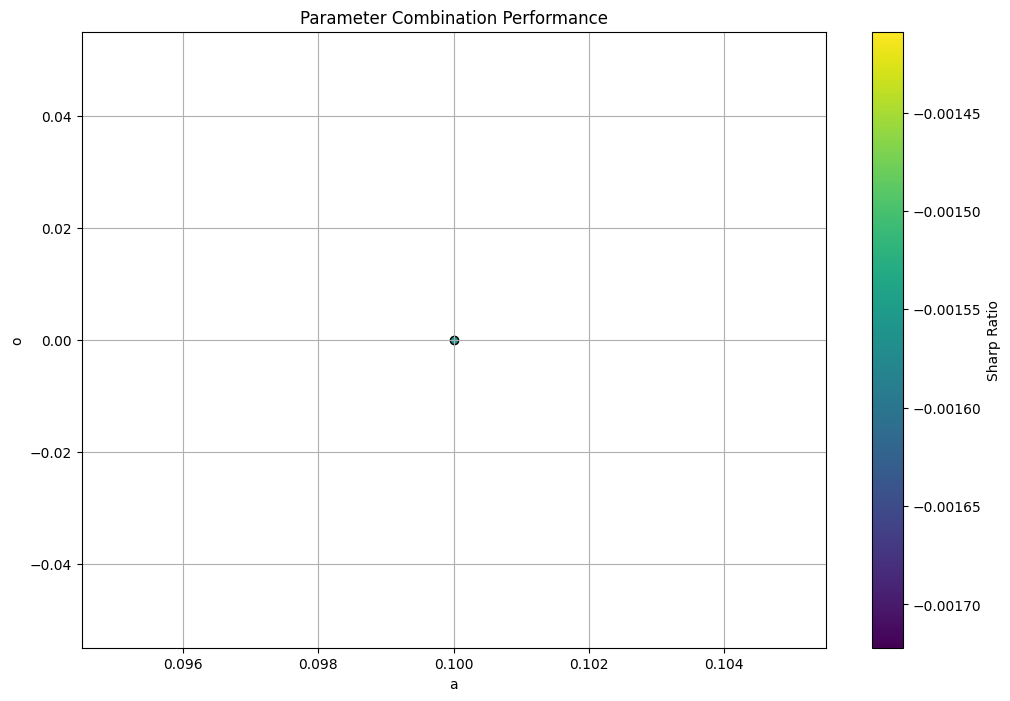

In [ ]:
a_values = results_df['a']
o_values = results_df['o']
sharp_ratios = results_df['metrics'].apply(lambda x: x['sharp_ratio'])

plt.figure(figsize=(12, 8))
sc = plt.scatter(a_values, o_values, c=sharp_ratios, cmap='viridis', edgecolors='k')
plt.colorbar(sc, label='sharp_ratio')
plt.xlabel('a')
plt.ylabel('o')
plt.title('Parameter Combination Performance')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个 DataFrame 以方便绘制热图
heatmap_data = results_df.pivot_table(
    values='metrics',
    index='a',
    columns='o'
)

# 从 metrics 中提取 sharp_ratio
heatmap_data = heatmap_data.applymap(lambda x: x['sharp_ratio'] if x is not None else 0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f')
plt.xlabel('o')
plt.ylabel('a')
plt.title('Parameter Combination Heatmap')
plt.show()


TypeError: agg function failed [how->mean,dtype->object]

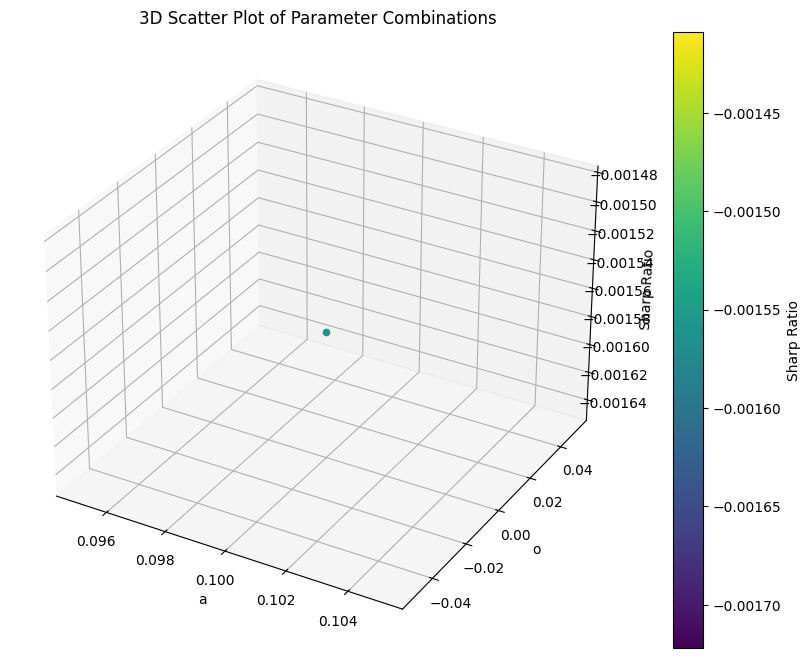

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

a_values = results_df['a']
o_values = results_df['o']
sharp_ratios = results_df['metrics'].apply(lambda x: x['sharp_ratio'])

scatter = ax.scatter(a_values, o_values, sharp_ratios, c=sharp_ratios, cmap='viridis')
fig.colorbar(scatter, ax=ax, label='sharp_ratio')
ax.set_xlabel('a')
ax.set_ylabel('o')
ax.set_zlabel('sharp_ratio')
ax.set_title('3D Scatter Plot of Parameter Combinations')

plt.show()
